In [1]:
import os
from PIL import ImageOps, ImageColor, Image, ImageDraw
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed
from utils import convert_coco_polygons_to_mask, overlay_mask

from datasets import load_dataset
from utils import resize_image_pil
import io
import numpy as np
import yaml 

In [2]:
repo_id = "jordandavis/fashion_people_detections"
parent_dir = "datasets/fashion_people_detection"
workers = os.cpu_count()

# Load Dataset
ds = load_dataset(
    repo_id, split="train", trust_remote_code=True, num_proc=workers, cache_dir='hf_cache'
)

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/24 [00:00<?, ?it/s]

In [24]:
def resize_image_pil(image_pil, max_size=1024):
    # Ensure image is in RGB
    if image_pil.mode != "RGB":
        image_pil = image_pil.convert("RGB")

    # Calculate new dimensions preserving aspect ratio
    width, height = image_pil.size
    scale = min(max_size / width, max_size / height)
    new_width = int(width * scale)
    new_height = int(height * scale)
    image_pil = image_pil.resize((new_width, new_height), Image.LANCZOS)

    # Calculate padding needed to reach 1024x1024
    pad_width = (max_size - new_width) // 2
    pad_height = (max_size - new_height) // 2

    # Apply padding symmetrically
    image_pil = ImageOps.expand(
        image_pil,
        border=(
            pad_width,
            pad_height,
            max_size - new_width - pad_width,
            max_size - new_height - pad_height,
        ),
        fill=(0, 0, 0),
    )

    return image_pil

In [3]:

# Load labels from YAML configuration file
yaml_file = "configs/fashion_people_detection.yml"
with open(yaml_file, 'r') as f:
    config = yaml.safe_load(f)
    class_labels = config['names']  # Adjust the key based on your YAML structure

In [4]:
labels = ['hair', 'face', 'neck', 'arm', 'hand', 'back', 'leg', 'foot', 'outfit', 'person', 'phone']
colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink', 'cyan', 'magenta', 'white', 'black']
label_to_color = dict(zip(labels, colors))

In [35]:
row = 5

100%|████████████████████████████████████████| 176M/176M [00:00<00:00, 180GB/s]


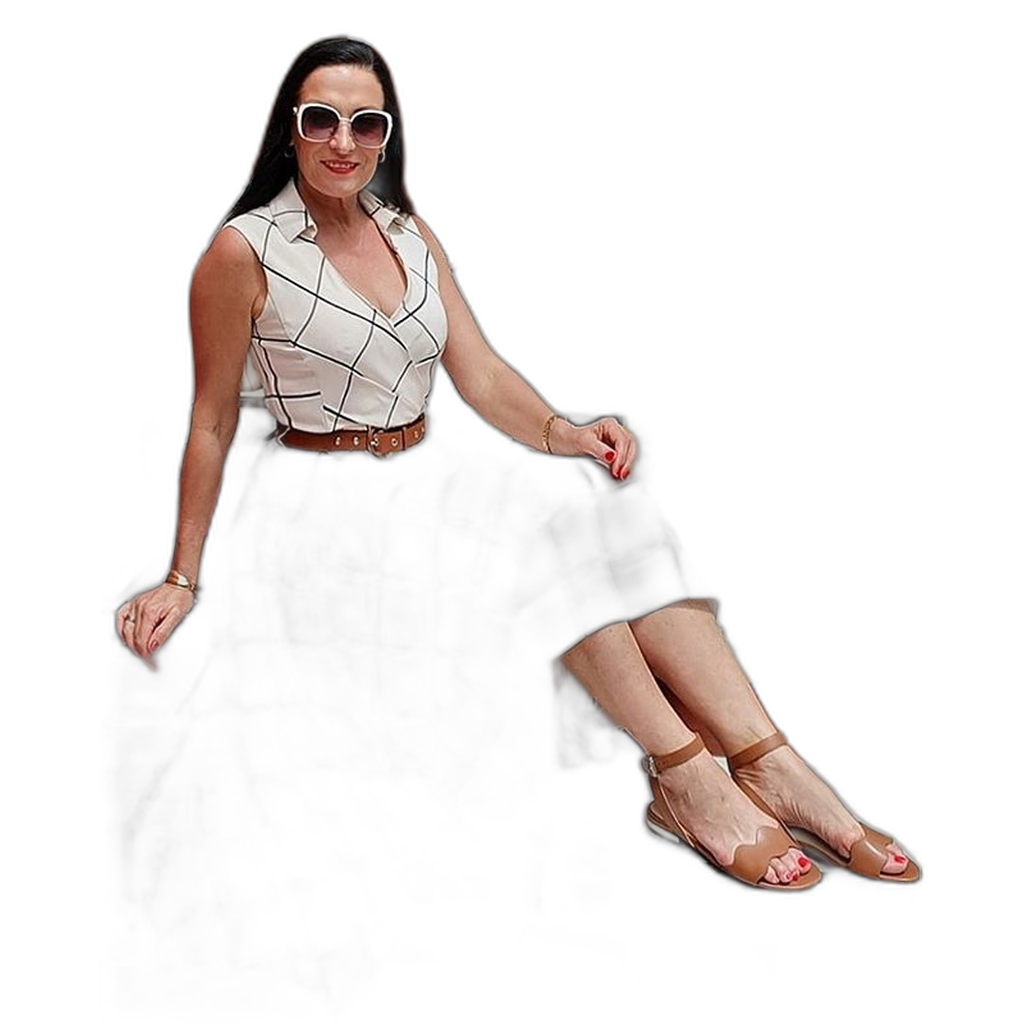

In [54]:
from rembg import remove
remove(image)

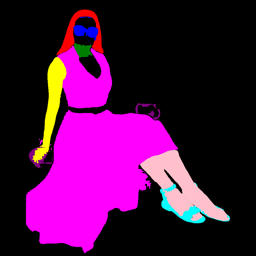

In [52]:
row += 1
image = ds[row]["image"]
image = resize_image_pil(image, 1024)
mask_md = ds[row]["mask_metadata"]
masks = []

for md in mask_md:
    polygons = md.get("polygons")
    label = md.get('label')
    if label not in ('person'):
        color = label_to_color.get(label)
        height, width = image.size
        mask = convert_coco_polygons_to_mask(polygons, height, width)
        mask = Image.fromarray(mask)
        masks.append((mask, color))

result = Image.new('RGB', image.size)
for mask, color in masks:
    colored = Image.new('RGB', image.size, color)
    result.paste(colored, mask=mask)

result.resize((256,256))